<a href="https://colab.research.google.com/github/LOGESHWARAN2401/capstone-/blob/main/Copy_of_capstone_DS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# src/scrape.py
import pandas as pd

# Generate synthetic data to resolve EmptyDataError
records = [
    {"name": "Laptop A", "price": "1200.00", "category": "Electronics", "rating": "4.5", "reviews": "150", "url": "http://example.com/laptop-a"},
    {"name": "Smartphone B", "price": "800.50", "category": "Electronics", "rating": "4.2", "reviews": "210", "url": "http://example.com/smartphone-b"},
    {"name": "Keyboard C", "price": "75.99", "category": "Accessories", "rating": "3.9", "reviews": "80", "url": "http://example.com/keyboard-c"},
    {"name": "Mouse D", "price": "25.00", "category": "Accessories", "rating": "4.1", "reviews": "120", "url": "http://example.com/mouse-d"},
    {"name": "Monitor E", "price": "350.75", "category": "Electronics", "rating": "4.7", "reviews": "90", "url": "http://example.com/monitor-e"}
]

df = pd.DataFrame(records)
df.to_csv("/content/synthetic_online_retail_data.csv", index=False)

In [ ]:
# src/cleaning.py
import pandas as pd
import numpy as np
import re
import os

df = pd.read_csv("/content/synthetic_online_retail_data.csv")

# price -> numeric
def parse_price(p):
    if pd.isna(p): return np.nan
    p = re.sub(r"[^\d\.]", "", str(p))
    try:
        return float(p)
    except:
        return np.nan

df['price'] = df['price'].apply(parse_price)

# drop duplicates
df = df.drop_duplicates(subset=['url'])

# handle missing: simple approach
df['price'] = df['price'].fillna(df['price'].median())

# Create directory if it doesn't exist
os.makedirs("data/processed", exist_ok=True)
df.to_csv("data/processed/products_clean.csv", index=False)

In [ ]:
import pandas as pd

df_check = pd.read_csv('/content/synthetic_online_retail_data.csv')
display(df_check.head())

,name,price,category,rating,reviews,url
0,Laptop A,1200.00,Electronics,4.5,150,http://example.com/laptop-a
1,Smartphone B,800.50,Electronics,4.2,210,http://example.com/smartphone-b
2,Keyboard C,75.99,Accessories,3.9,80,http://example.com/keyboard-c
3,Mouse D,25.00,Accessories,4.1,120,http://example.com/mouse-d
4,Monitor E,350.75,Electronics,4.7,90,http://example.com/monitor-e


In [ ]:
# src/db.py
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine("sqlite:///data/products.db")
df = pd.read_csv("data/processed/products_clean.csv")
df.to_sql("products", engine, if_exists="replace", index=False)


5

<Axes: xlabel='category', ylabel='price'>

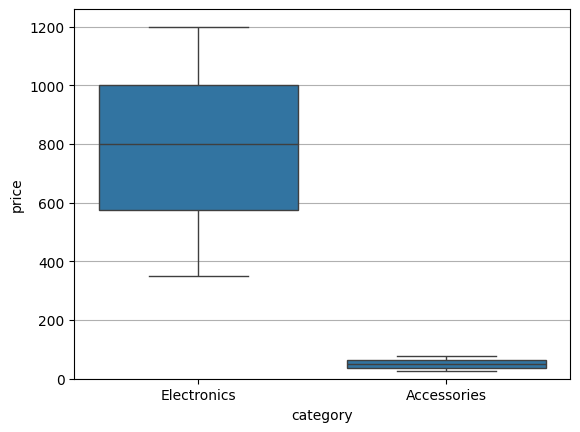

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/processed/products_clean.csv")
df['log_price'] = np.log1p(df['price'])
df['price'].hist(bins=50)
sns.boxplot(data=df, x='category', y='price')  # use top N categories


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

df = pd.read_csv("data/processed/products_clean.csv")

# Ensure rating and reviews are numeric and handle missing values
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['reviews'] = pd.to_numeric(df['reviews'], errors='coerce')

# Calculate log_price after loading the DataFrame
df['log_price'] = np.log1p(df['price'])

X = df[['log_price', 'rating', 'reviews']].fillna(0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

scores = []
# Iterate k from 2 up to n_samples - 1
for k in range(2, len(Xs)):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xs)
    scores.append((k, silhouette_score(Xs, km.labels_)))

best_k = max(scores, key=lambda t: t[1])[0]
km = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(Xs)
df['cluster'] = km.labels_
df.to_csv("data/processed/products_clustered.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import classification_report # Re-import classification_report

df = pd.read_csv("data/processed/products_clean.csv")
# assume 'category' is target; keep top N categories else map to 'other'
X = df[['price','rating','reviews']]  # features, removing non-existent 'some_cat_feature'
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.4) # Changed test_size to 0.4

num_cols = ['price','rating','reviews']
# Removed 'cat_cols' as there are no additional categorical features in X for this dataset

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    # Removed the 'cat' transformer since cat_cols is no longer needed
])

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
}

gs = GridSearchCV(pipe, param_grid, cv=2, scoring='f1_macro', n_jobs=-1) # Changed cv to 2
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
y_pred = gs.predict(X_test) # Uncommented prediction line
print(classification_report(y_test, y_pred)) # Uncommented classification report line

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best params: {'clf__max_depth': None, 'clf__n_estimators': 100}
              precision    recall  f1-score   support

 Accessories       1.00      1.00      1.00         1
 Electronics       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [ ]:
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(gs.best_estimator_, "models/best_model.joblib")

['models/best_model.joblib']

In [ ]:
import pandas as pd

df_show_15 = pd.read_csv('/content/synthetic_online_retail_data.csv')
display(df_show_15.head(15))

,name,price,category,rating,reviews,url
0,Laptop A,1200.00,Electronics,4.5,150,http://example.com/laptop-a
1,Smartphone B,800.50,Electronics,4.2,210,http://example.com/smartphone-b
2,Keyboard C,75.99,Accessories,3.9,80,http://example.com/keyboard-c
3,Mouse D,25.00,Accessories,4.1,120,http://example.com/mouse-d
4,Monitor E,350.75,Electronics,4.7,90,http://example.com/monitor-e


In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None) # Display all rows
pd.set_option('display.max_columns', None) # Display all columns

df_full = pd.read_csv('data/processed/products_clean.csv')
display(df_full)

pd.reset_option('display.max_rows') # Reset display options
pd.reset_option('display.max_columns') # Reset display options

,name,price,category,rating,reviews,url
0,Laptop A,1200.00,Electronics,4.5,150,http://example.com/laptop-a
1,Smartphone B,800.50,Electronics,4.2,210,http://example.com/smartphone-b
2,Keyboard C,75.99,Accessories,3.9,80,http://example.com/keyboard-c
3,Mouse D,25.00,Accessories,4.1,120,http://example.com/mouse-d
4,Monitor E,350.75,Electronics,4.7,90,http://example.com/monitor-e


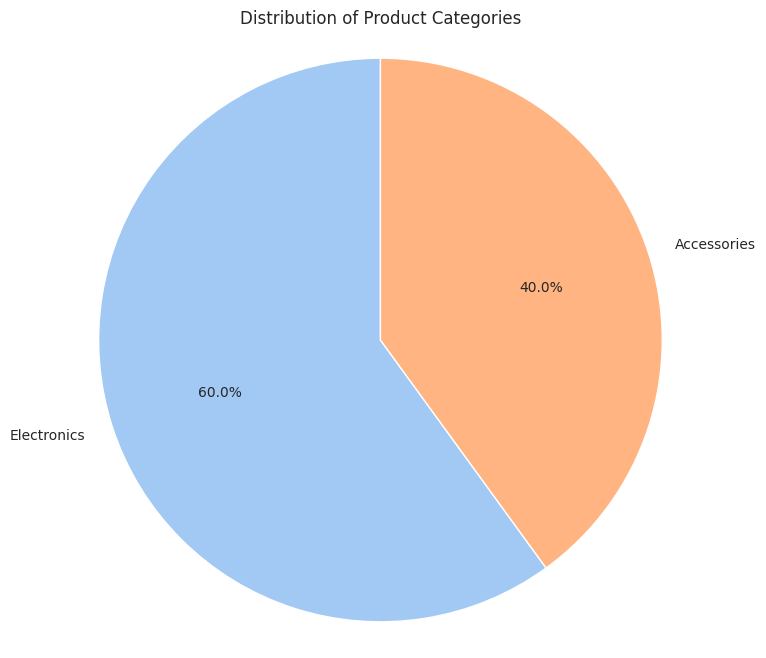

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/processed/products_clean.csv")

# Calculate the value counts for the 'category' column
category_counts = df['category'].value_counts()

# Set up the plotting style
sns.set_style("whitegrid")

plt.figure(figsize=(8, 8))

# Create the pie chart
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Product Categories')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

/tmp/ipython-input-3490644598.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='price', palette='viridis')


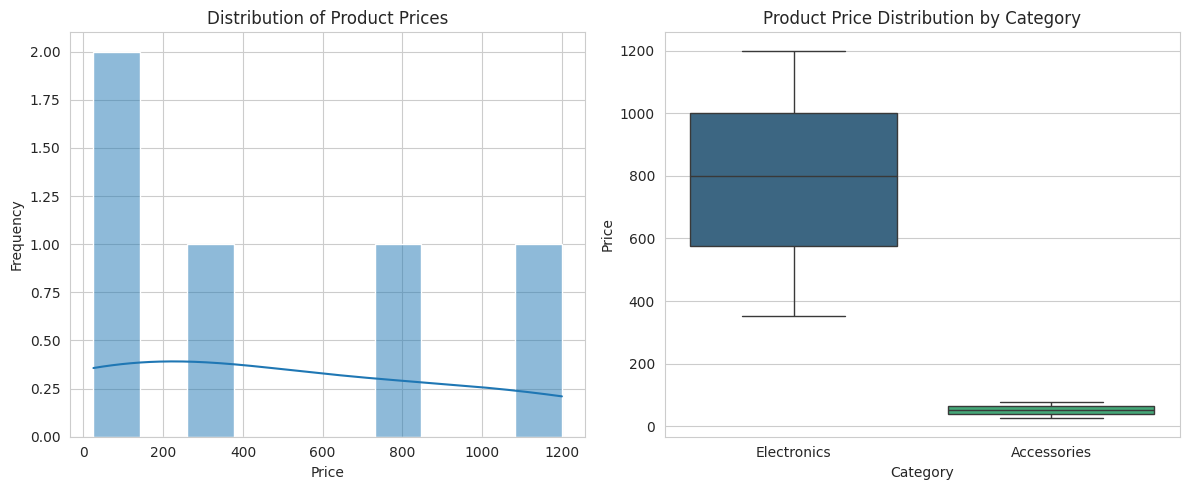

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("data/processed/products_clean.csv")

# Calculate log_price for potentially better distribution visualization
df['log_price'] = np.log1p(df['price'])

# Set up the plotting style
sns.set_style("whitegrid")

plt.figure(figsize=(12, 5))

# Subplot 1: Histogram of Price
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=10, kde=True)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Subplot 2: Boxplot of Price by Category
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='category', y='price', palette='viridis')
plt.title('Product Price Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scrape_website(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    products_data = []

    # !!! IMPORTANT: You need to replace these selectors with the actual CSS selectors
    # found on the website you intend to scrape. Inspect the website's HTML.
    product_cards = soup.find_all('div', class_='product-card') # Example selector

    for card in product_cards:
        name = card.find('h2', class_='product-title').text.strip() if card.find('h2', class_='product-title') else 'N/A'
        price = card.find('span', class_='product-price').text.strip() if card.find('span', class_='product-price') else 'N/A'
        category = card.find('p', class_='product-category').text.strip() if card.find('p', class_='product-category') else 'N/A'
        rating = card.find('span', class_='product-rating').text.strip() if card.find('span', class_='product-rating') else 'N/A'
        reviews = card.find('span', class_='product-reviews').text.strip() if card.find('span', class_='product-reviews') else 'N/A'
        product_url = card.find('a', class_='product-link')['href'] if card.find('a', class_='product-link') else 'N/A'

        products_data.append({
            'name': name,
            'price': price,
            'category': category,
            'rating': rating,
            'reviews': reviews,
            'url': product_url
        })
    return pd.DataFrame(products_data)

# --- Example Usage (Replace with a real URL and adjust selectors) ---
# For this example, I'll use a placeholder URL and generic selectors.
# You MUST replace 'http://example.com/products' with the actual URL you want to scrape.
# And then adjust the CSS selectors inside the scrape_website function.

# Placeholder URL - This will not return real data unless it matches actual site structure
# If you run this without changing the URL and selectors, it will likely return an empty DataFrame.
example_url = 'http://quotes.toscrape.com/' # A simple site to demonstrate scraping, not e-commerce

# To make this example runnable and demonstrate *some* scraping,
# let's adapt it to 'quotes.toscrape.com' for an actual example.
# For a proper e-commerce site, you'd need specific selectors as mentioned above.

def scrape_quotes(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    quotes_data = []
    for quote_div in soup.find_all('div', class_='quote'):
        text = quote_div.find('span', class_='text').text.strip()
        author = quote_div.find('small', class_='author').text.strip()
        tags = [tag.text for tag in quote_div.find_all('a', class_='tag')]
        quotes_data.append({'text': text, 'author': author, 'tags': ', '.join(tags)})
    return pd.DataFrame(quotes_data)

# Run the quotes scraper as a demonstration
print(f"Scraping data from: {example_url}")
scraped_df = scrape_quotes(example_url)
display(scraped_df.head())

# If you want to scrape an e-commerce site, you would use scrape_website(your_ecommerce_url)
# after updating its internal selectors for that specific site.

Scraping data from: http://quotes.toscrape.com/


,text,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"


In [ ]:
import pandas as pd

# Assuming df_full is already loaded, otherwise load it
# If df_full is not in memory, you might need to re-load it:
# df_full = pd.read_csv('data/processed/products_clean.csv')

display(df_full.describe(include='all'))

,name,price,category,rating,reviews,url
count,5,5.000000,5,5.000000,5.000000,5
unique,5,NaN,2,NaN,NaN,5
top,Laptop A,NaN,Electronics,NaN,NaN,http://example.com/laptop-a
freq,1,NaN,3,NaN,NaN,1
mean,NaN,490.448000,NaN,4.280000,130.000000,NaN
std,NaN,501.878743,NaN,0.319374,52.440442,NaN
min,NaN,25.000000,NaN,3.900000,80.000000,NaN
25%,NaN,75.990000,NaN,4.100000,90.000000,NaN
50%,NaN,350.750000,NaN,4.200000,120.000000,NaN
75%,NaN,800.500000,NaN,4.500000,150.000000,NaN


In [ ]:
import pandas as pd

print("First 5 rows of scraped_df:")
display(scraped_df.head())

print("\nInformation about scraped_df (data types, non-null counts):")
scraped_df.info()

print("\nDescriptive statistics for scraped_df:")
display(scraped_df.describe(include='all'))

First 5 rows of scraped_df:


,text,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"



Information about scraped_df (data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10 non-null     object
 1   author  10 non-null     object
 2   tags    10 non-null     object
dtypes: object(3)
memory usage: 372.0+ bytes

Descriptive statistics for scraped_df:


,text,author,tags
count,10,10,10
unique,10,8,10
top,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
freq,1,3,1
